In [29]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

In [2]:
# Charger le dataset
file_path = 'data/truck_sales.csv'
data = pd.read_csv(file_path)

# Afficher un aperçu des données
print("\n=== Aperçu des premières lignes ===")
print(data.head())


=== Aperçu des premières lignes ===
  Month-Year  Number_Trucks_Sold
0     03-Jan                 155
1     03-Feb                 173
2     03-Mar                 204
3     03-Apr                 219
4     03-May                 223


In [3]:
# Statistiques descriptives
print("\nStatistiques descriptives :\n", data.describe())


Statistiques descriptives :
        Number_Trucks_Sold
count          144.000000
mean           428.729167
std            188.633037
min            152.000000
25%            273.500000
50%            406.000000
75%            560.250000
max            958.000000


In [4]:
# Vérifier les valeurs manquantes
missing_values = data.isnull().sum()
print("\nValeurs manquantes :\n", missing_values)


Valeurs manquantes :
 Month-Year            0
Number_Trucks_Sold    0
dtype: int64


In [5]:
# Vérifier les types de données
print("\nTypes de données :\n", data.dtypes)


Types de données :
 Month-Year            object
Number_Trucks_Sold     int64
dtype: object


In [6]:
# Convertir la colonne 'Month-Year' en format datetime et renommer
data['Date'] = pd.to_datetime(data['Month-Year'], format='%y-%b')
data = data.rename(columns={'Number_Trucks_Sold': 'Sales'})
data = data.drop(columns=['Month-Year'])  # Supprimer l'ancienne colonne inutile

In [7]:
# Vérifier la plage de dates
print("\nPlage de dates :", data['Date'].min(), "à", data['Date'].max())


Plage de dates : 2003-01-01 00:00:00 à 2014-12-01 00:00:00


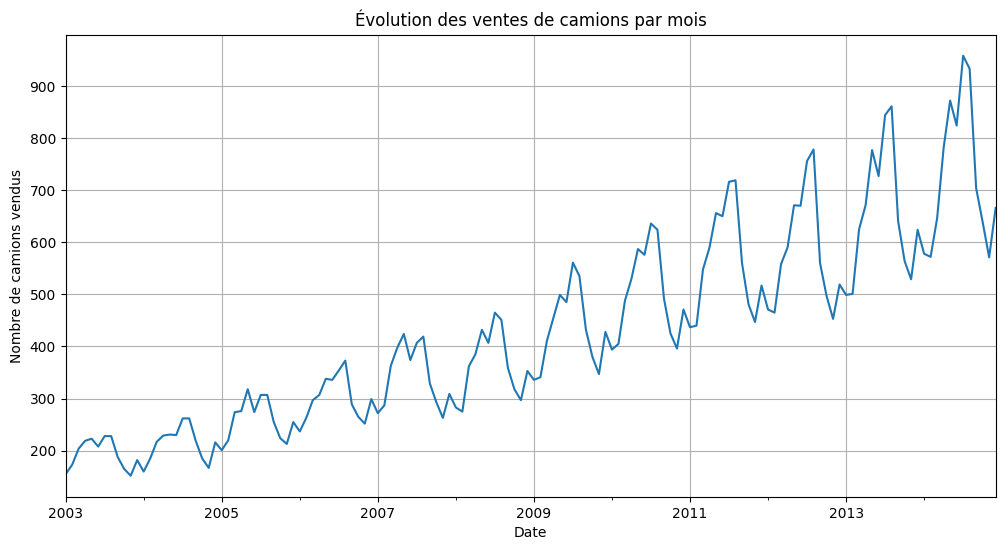

In [8]:
# Vérifier la distribution temporelle des ventes
plt.figure(figsize=(12, 6))
data.set_index('Date')['Sales'].plot()
plt.title("Évolution des ventes de camions par mois")
plt.xlabel("Date")
plt.ylabel("Nombre de camions vendus")
plt.grid()
plt.show()

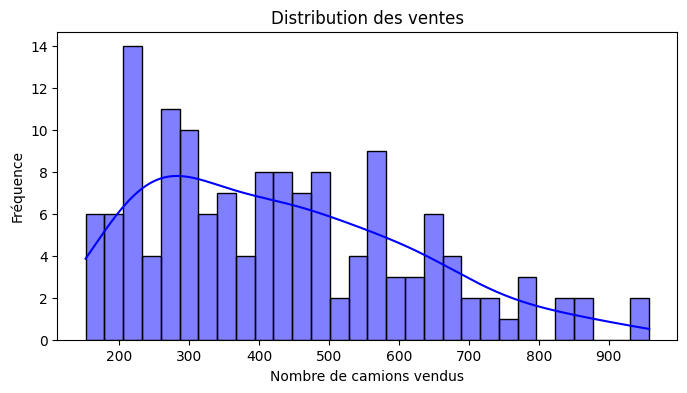

In [9]:
# Visualisation de la distribution des ventes
plt.figure(figsize=(8, 4))
sns.histplot(data['Sales'], bins=30, kde=True, color='blue')
plt.title("Distribution des ventes")
plt.xlabel("Nombre de camions vendus")
plt.ylabel("Fréquence")
plt.show()

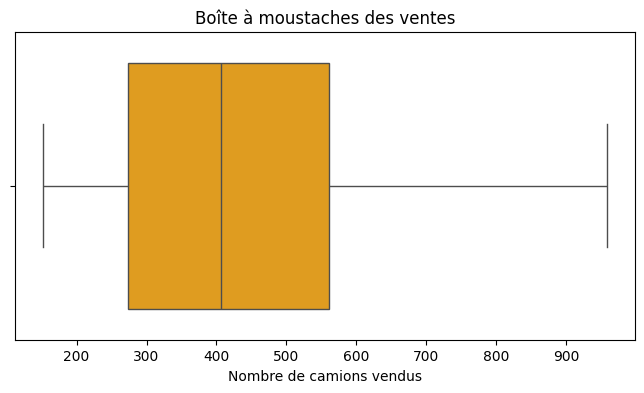

In [10]:
# Boîte à moustaches pour détecter les valeurs aberrantes
plt.figure(figsize=(8, 4))
sns.boxplot(x=data['Sales'], color='orange')
plt.title("Boîte à moustaches des ventes")
plt.xlabel("Nombre de camions vendus")
plt.show()

In [11]:
# Trier les données par date (au cas où)
data = data.sort_values(by='Date')

# Réindexer par la colonne 'Date'
data.set_index('Date', inplace=True)

# Afficher un aperçu des données transformées
print("\n=== Données après conversion et transformation ===")
print(data.head())


=== Données après conversion et transformation ===
            Sales
Date             
2003-01-01    155
2003-02-01    173
2003-03-01    204
2003-04-01    219
2003-05-01    223


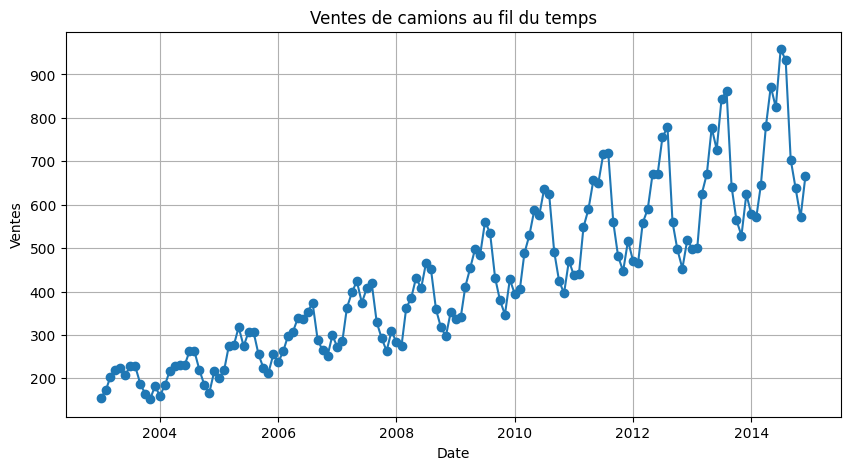

In [12]:
# Visualiser la série temporelle
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Sales'], marker='o')
plt.title("Ventes de camions au fil du temps")
plt.xlabel("Date")
plt.ylabel("Ventes")
plt.grid()
plt.show()

In [13]:
warnings.filterwarnings("ignore")  # Ignorer les warnings pour une sortie plus propre

auto_model = auto_arima(
    data['Sales'],
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True,
    error_action='ignore',
    max_p=5, max_d=2, max_q=5,
)

# Résumé des meilleurs paramètres trouvés
print("\n=== Meilleurs paramètres ARIMA ===")
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1591.981, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1590.212, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1589.735, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1590.450, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1578.003, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1591.484, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1591.297, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1576.449, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1588.110, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1588.577, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1575.284, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1589.7

In [14]:
# split train/test
train_size = int(len(data) * 0.8)
arima_train = data.iloc[:train_size]
arima_test  = data.iloc[train_size:]

In [15]:
# Ajuster le modèle ARIMA avec les meilleurs paramètres
arima_model = auto_model.fit(arima_train['Sales'])

In [16]:
# Prédire sur l'horizon du test
arima_test_predictions = arima_model.predict(n_periods=len(arima_test))

In [17]:
# Ajouter les prédictions dans le DataFrame de test
arima_test = arima_test.copy()
arima_test['Predictions'] = arima_test_predictions

# Calcul des métriques
mae = mean_absolute_error(arima_test['Sales'], arima_test['Predictions'])
rmse = np.sqrt(mean_squared_error(arima_test['Sales'], arima_test['Predictions']))
mape = np.mean(np.abs((arima_test['Sales'] - arima_test['Predictions']) / arima_test['Sales'])) * 100

print("\n=== Métriques de performance ===")
print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")


=== Métriques de performance ===
MAE : 83.56
RMSE : 100.67
MAPE : 12.39%


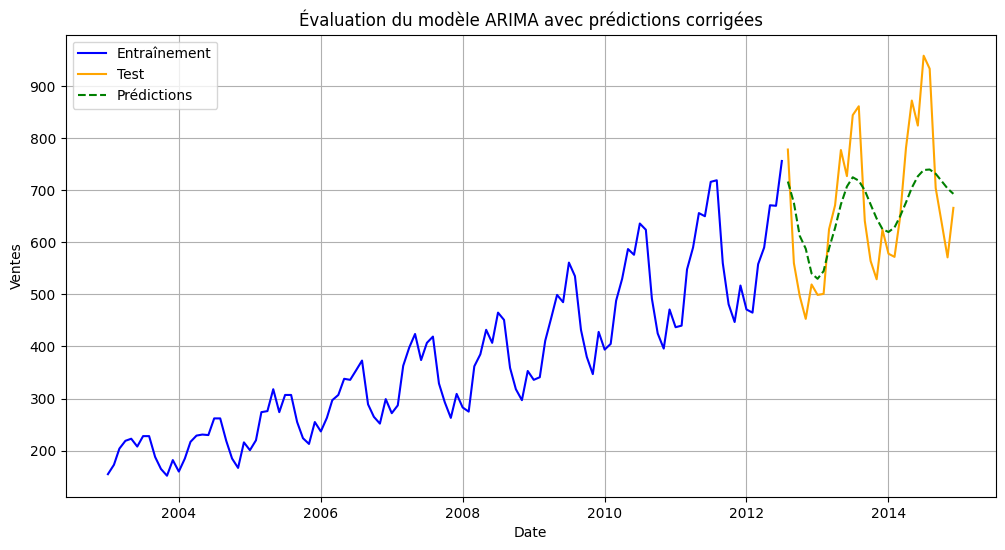

In [18]:
# Tracer le graphique avec les prédictions corrigées
plt.figure(figsize=(12, 6))
plt.plot(arima_train['Sales'], label="Entraînement", color="blue")
plt.plot(arima_test['Sales'], label="Test", color="orange")
plt.plot(arima_test['Predictions'], label="Prédictions", linestyle="--", color="green")
plt.title("Évaluation du modèle ARIMA avec prédictions corrigées")
plt.xlabel("Date")
plt.ylabel("Ventes")
plt.legend()
plt.grid()
plt.show()

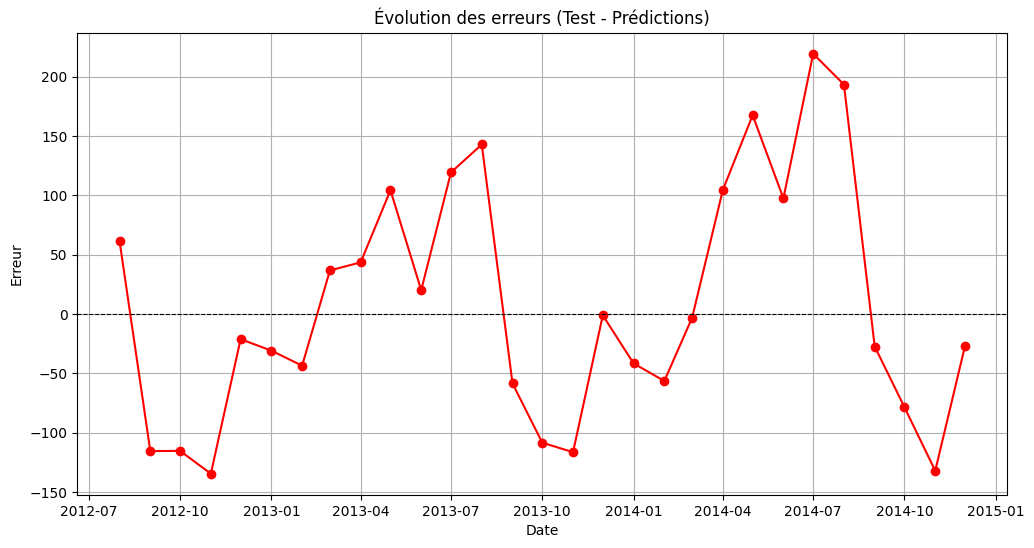

In [21]:
# Graphique linéaire des erreurs
plt.figure(figsize=(12, 6))
plt.plot(arima_test.index, errors, marker='o', linestyle='-', color='red')
plt.title("Évolution des erreurs (Test - Prédictions)")
plt.xlabel("Date")
plt.ylabel("Erreur")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.grid()
plt.show()

In [22]:
# Ajouter une colonne pour l'année et le trimestre
arima_test['Year'] = arima_test.index.year
arima_test['Quarter'] = arima_test.index.quarter

# Calculer les erreurs moyennes par année et par trimestre
error_by_year = arima_test.groupby('Year').apply(
    lambda x: np.mean(x['Sales'] - x['Predictions'])
)
error_by_quarter = arima_test.groupby(['Year', 'Quarter']).apply(
    lambda x: np.mean(x['Sales'] - x['Predictions'])
)

# Afficher les erreurs moyennes par année
print("\n=== Erreurs moyennes par année ===")
print(error_by_year)


=== Erreurs moyennes par année ===
Year
2012   -65.108492
2013     8.928508
2014    34.615506
dtype: float64


In [23]:
# Afficher les erreurs moyennes par trimestre
print("\n=== Erreurs moyennes par trimestre ===")
print(error_by_quarter)


=== Erreurs moyennes par trimestre ===
Year  Quarter
2012  3          -27.081036
      4          -90.460129
2013  1          -12.638819
      2           55.928725
      3           67.832489
      4          -75.408362
2014  1          -33.816900
      2          123.157119
      3          128.406600
      4          -79.284795
dtype: float64


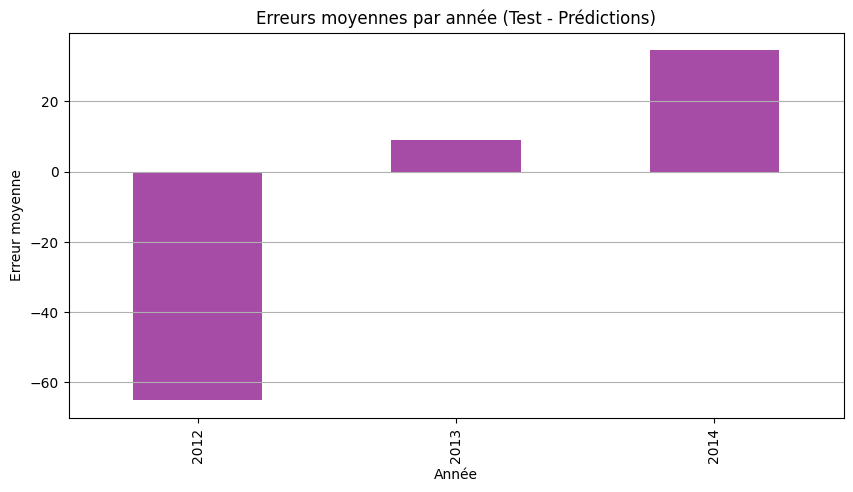

In [24]:
# Visualiser les erreurs moyennes par année
plt.figure(figsize=(10, 5))
error_by_year.plot(kind='bar', color='purple', alpha=0.7)
plt.title("Erreurs moyennes par année (Test - Prédictions)")
plt.xlabel("Année")
plt.ylabel("Erreur moyenne")
plt.grid(axis='y')
plt.show()

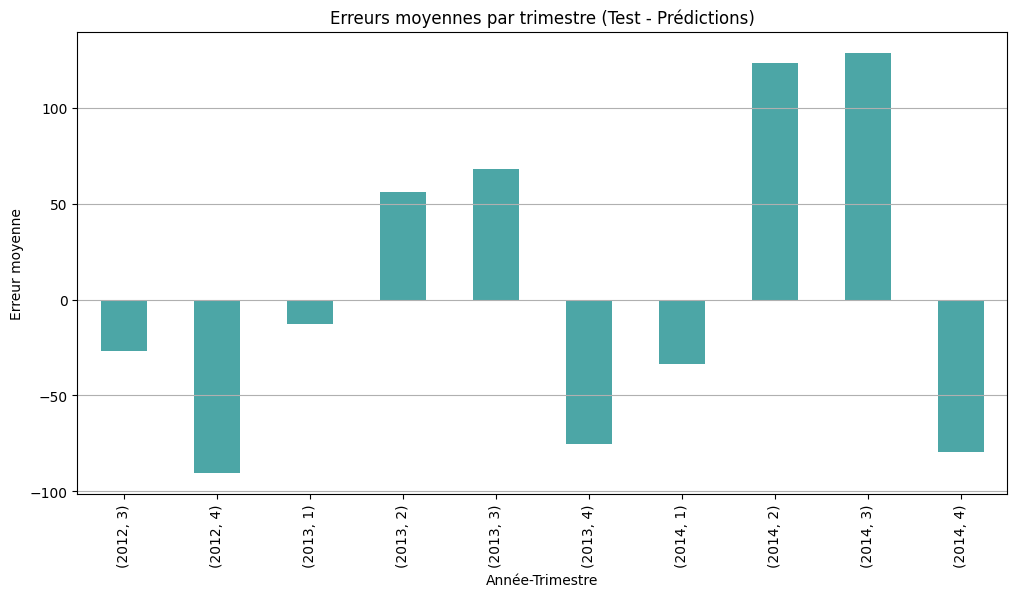

In [25]:
# Visualiser les erreurs moyennes par trimestre
plt.figure(figsize=(12, 6))
error_by_quarter.plot(kind='bar', color='teal', alpha=0.7)
plt.title("Erreurs moyennes par trimestre (Test - Prédictions)")
plt.xlabel("Année-Trimestre")
plt.ylabel("Erreur moyenne")
plt.grid(axis='y')
plt.show()

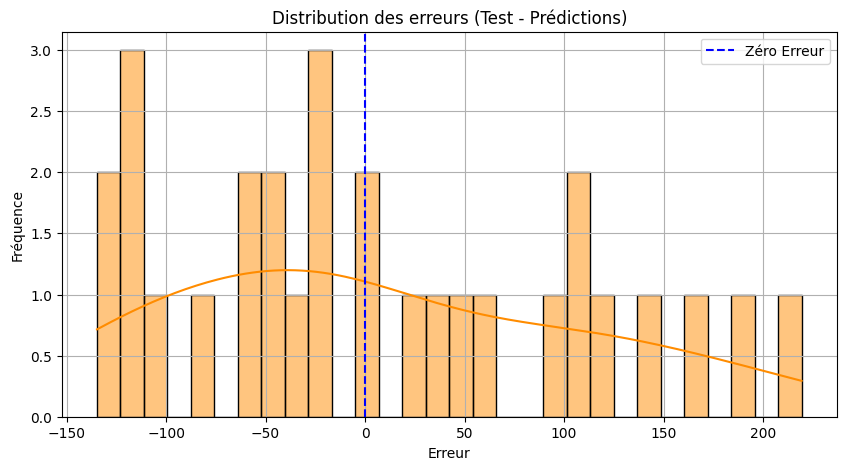

In [26]:
# Calculer les erreurs
errors = arima_test['Sales'] - arima_test['Predictions']

# Visualiser la distribution des erreurs
plt.figure(figsize=(10, 5))
sns.histplot(errors, kde=True, bins=30, color="darkorange")
plt.title("Distribution des erreurs (Test - Prédictions)")
plt.xlabel("Erreur")
plt.ylabel("Fréquence")
plt.axvline(0, color='blue', linestyle='--', label='Zéro Erreur')
plt.legend()
plt.grid()
plt.show()

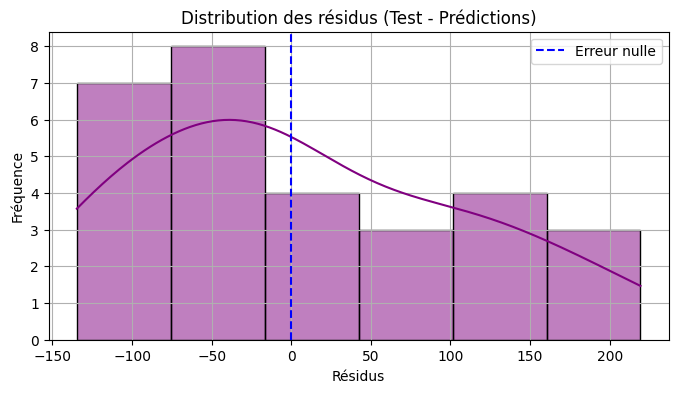

In [27]:
# Visualiser les résidus pour détecter des biais
arima_test['Residuals'] = arima_test['Sales'] - arima_test['Predictions']

# Distribution des résidus
plt.figure(figsize=(8, 4))
sns.histplot(arima_test['Residuals'], kde=True, color="purple")
plt.axvline(0, color="blue", linestyle="--", label="Erreur nulle")
plt.title("Distribution des résidus (Test - Prédictions)")
plt.xlabel("Résidus")
plt.ylabel("Fréquence")
plt.legend()
plt.grid()
plt.show()

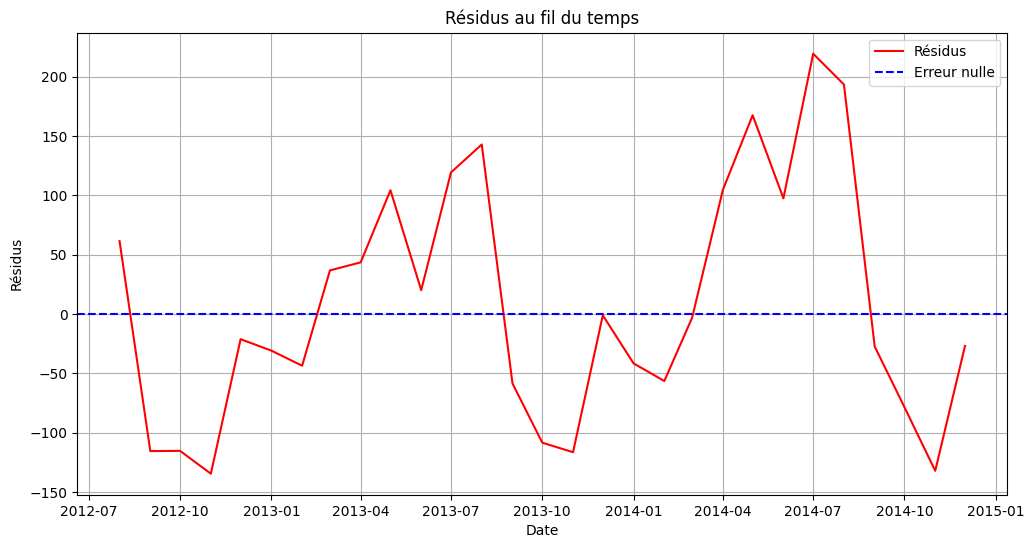

In [28]:
# Résidus en série temporelle
plt.figure(figsize=(12, 6))
plt.plot(arima_test.index, arima_test['Residuals'], color="red", label="Résidus")
plt.axhline(0, color="blue", linestyle="--", label="Erreur nulle")
plt.title("Résidus au fil du temps")
plt.xlabel("Date")
plt.ylabel("Résidus")
plt.legend()
plt.grid()
plt.show()

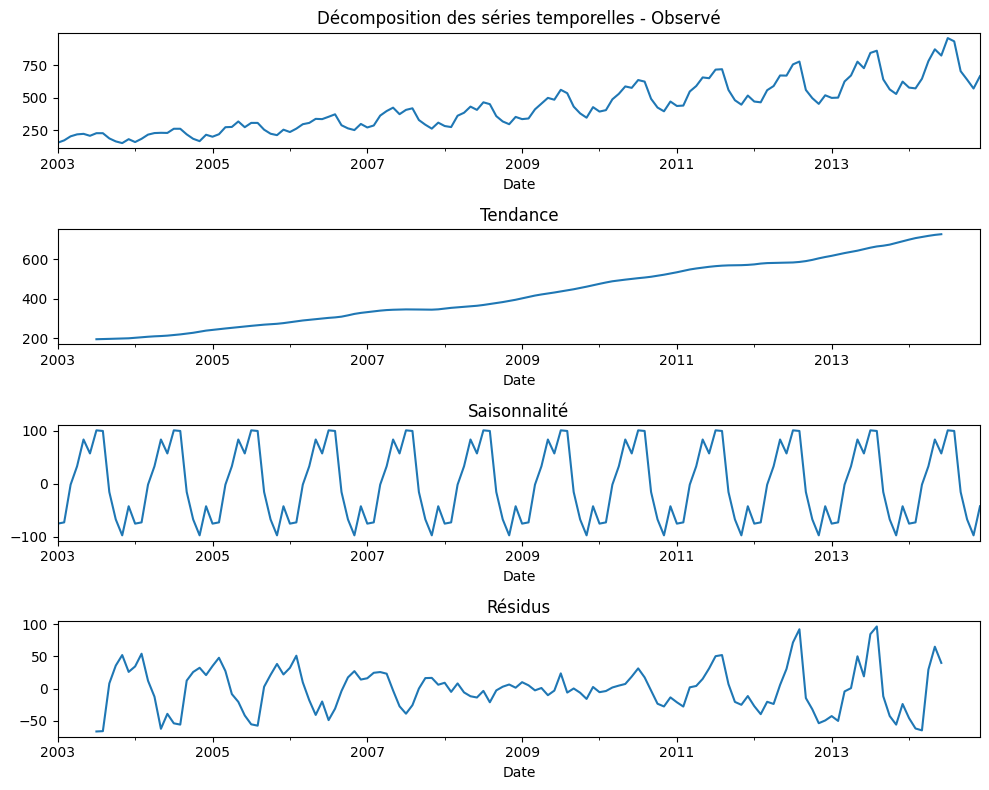

In [31]:
# Décomposer la série temporelle
decomposition = seasonal_decompose(data['Sales'], model='additive', period=12)

# Ajuster la taille de la figure
fig, axes = plt.subplots(4, 1, figsize=(10, 8))  # 4 lignes, 1 colonne

# Tracer les composantes
decomposition.observed.plot(ax=axes[0], title="Décomposition des séries temporelles - Observé")
decomposition.trend.plot(ax=axes[1], title="Tendance")
decomposition.seasonal.plot(ax=axes[2], title="Saisonnalité")
decomposition.resid.plot(ax=axes[3], title="Résidus")

# Appliquer une mise en page propre pour éviter les chevauchements
plt.tight_layout()
plt.show()